# Modeling fish production, using Stock et al. 2017 equations. 
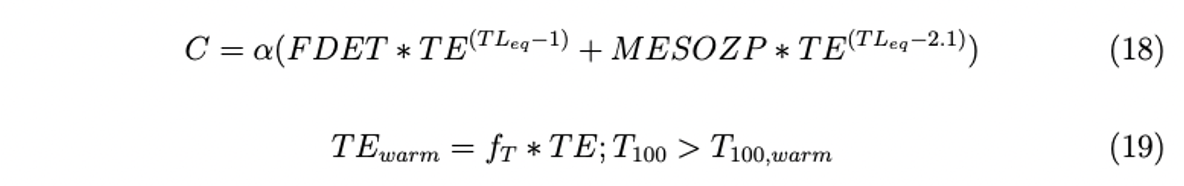

__{$\alpha$}__ = harvesting factor interpreted as the fraction of energy available at TL$_{eq}$ that is realized as catch

* in Stock et al. 2017, single values of TE and $\alpha$  are fit across LMEs such that any interregional variation in these parameters would appear as unexplained catch variance

* __{$\alpha$} was constrained between 0 and 1.__ 

__FDET__ = energy available from the plankton food web via the flux of detritus to sediment 

__TE__ = trophic transfer efficincy, controlling the decay of energy between trophic levels. This is a dimensionless free paramter controlling the decay of energy between trophic levels. 

* __values of TE were constrained within typical observed ranges of 0-0.4__
    * (Pauly D, Christensen V (1995) Primary production required to sustain global fisheries. Nature 374(6519):255–257.)
    * Libralato S, Coll M, Tudela S, Palomera I, Pranovi F (2008) Novel index for quantification of ecosystem effects of fishing as removal of secondary production. Mar Ecol Prog Ser 355:107–129.

__TL$_{eq}$__ = equivalent trophic level of the aggreagte catch derived from FishBase. It scaled by a trophic level of 1 for FDET and 2.1 for MESOZP from the fish catch. 

* Phytoplankton are assigned to trophic level 1, such that TL$_{eq}$ - 1 is the number of trophic steps separating phytoplankton from the fish catch.  

__MESOZP__ = mesozooplankton production not consumed by other zooplankton


In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import hvplot.xarray
import xarray as xr
import cartopy.crs as ccrs

import geoviews as gv
import holoviews as hv
import numpy as np
import math
from matplotlib.pyplot import figure

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

import seaborn as sns
import scipy.io as sio

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
import os
import matplotlib.gridspec as gridspec
import matplotlib
import cartopy
import matplotlib.colors as colors
import cmocean

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [4]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim/clim_20yr_GNG595_*', recursive=True),
                      key=numericalSort)

ds= xr.open_mfdataset(newNCDFfiles,combine='by_coords')

### __FDET__ = energy available from the plankton food web via the flux of detritus to sediment 

In [5]:
ds.POC_FLUX_IN

<xarray.DataArray 'POC_FLUX_IN' (time: 12, z_t: 60, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(12, 60, 384, 320), dtype=float32, chunksize=(1, 60, 384, 320)>
Coordinates:
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t      (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
  * time     (time) object 0104-02-01 00:00:00 ... 0105-01-01 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     POC Flux into Cell
    units:         mmol/m^3 cm/s
    grid_loc:      3111
    cell_methods:  time: mean

Flux = ds.POC_FLUX_IN[:,:,:,:].mean(dim='time') * (60*60*24*365)/100 * 12.011 / 1e3 # mmol/m^3 cm/s --> mmol/m^2/y ----> g/m^2/y

kmt_bottom = np.nanmean(ds.KMT,axis=0)
flux_bottom = np.empty([12,384,320]) # Size of the array that I need
flux_bottom[:] = np.nan # make everything a nan inside of it
for i in range(384): # loop through the latitude 
    for j in range(320): # loop through the longitude 
        # For each lat and lon, find the bottom depth, and select that flux as the bottom flux of each grid cell. 
        # I averaged the bottom depth annually before becuase I do not expect the bottom depth to change seasonally right?
        if kmt_bottom[i,j] == 0: 
            flux_bottom[:,i,j] =  ds.POC_FLUX_IN[:,0,i,j]# mmol/m^3 cm/s
        else:
            flux_bottom[:,i,j] =  ds.POC_FLUX_IN[:,np.int(kmt_bottom[i,j])-1,i,j]# mmol/m^3 cm/s
        

np.save("/glade/scratch/gabyn/SPECTRA/flux_bottom.npy",flux_bottom)

In [6]:
flux_bottom = np.load("/glade/scratch/gabyn/SPECTRA/flux_bottom.npy")

In [7]:
flux_bottom.shape

(12, 384, 320)

In [8]:
flux_bottom_depth = flux_bottom * (60*60*24*365)/100 * 12.011 / 1e3 #g/m^2/y

In [9]:
flux_bottom_depth.shape

(12, 384, 320)

### Compare FDET/NPP with Stock et al. 2017

In [10]:
total_npp = ds.photoC_TOT.sum(dim='z_t_150m') * 10 # (10 = depth of each layer) integrate over depth mmol/m^3/s to #mmol m-2 s-1
total_npp = total_npp.mean(dim='time') * (60*60*24*365) # mmol m-2 y-1
total_npp = total_npp * 12.011 / 1e3 # g/m^2/y

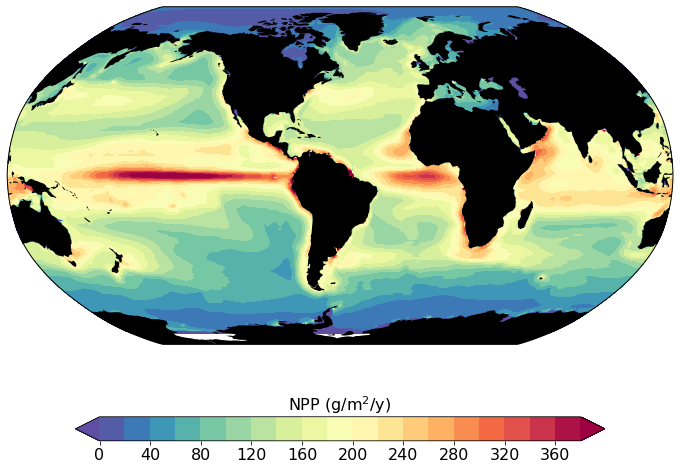

In [11]:
fig = plt.figure(figsize=(15, 7))
lev = np.arange(0, 400, 20)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=200)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, total_npp)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_global()
cb.ax.set_title('NPP (g/m$^2$/y)', fontsize = 16)
cb.ax.tick_params(labelsize=16)
fig.tight_layout()

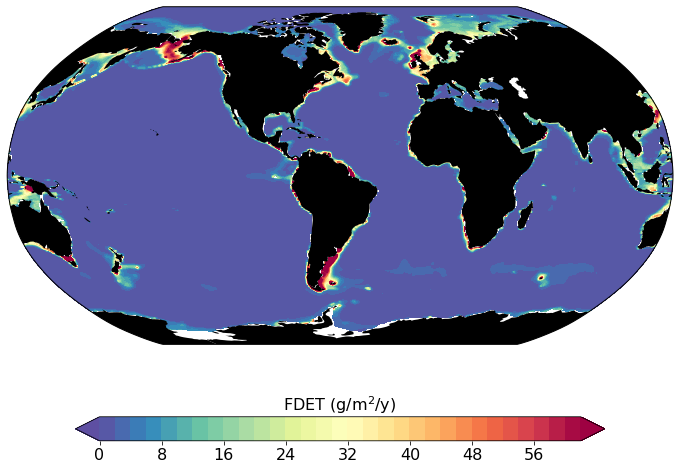

In [12]:
fig = plt.figure(figsize=(15, 7))
lev = np.arange(0, 64, 2)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=32)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(flux_bottom_depth,axis=0))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_global()
cb.ax.set_title('FDET (g/m$^2$/y)', fontsize = 16)
cb.ax.tick_params(labelsize=16)
fig.tight_layout()

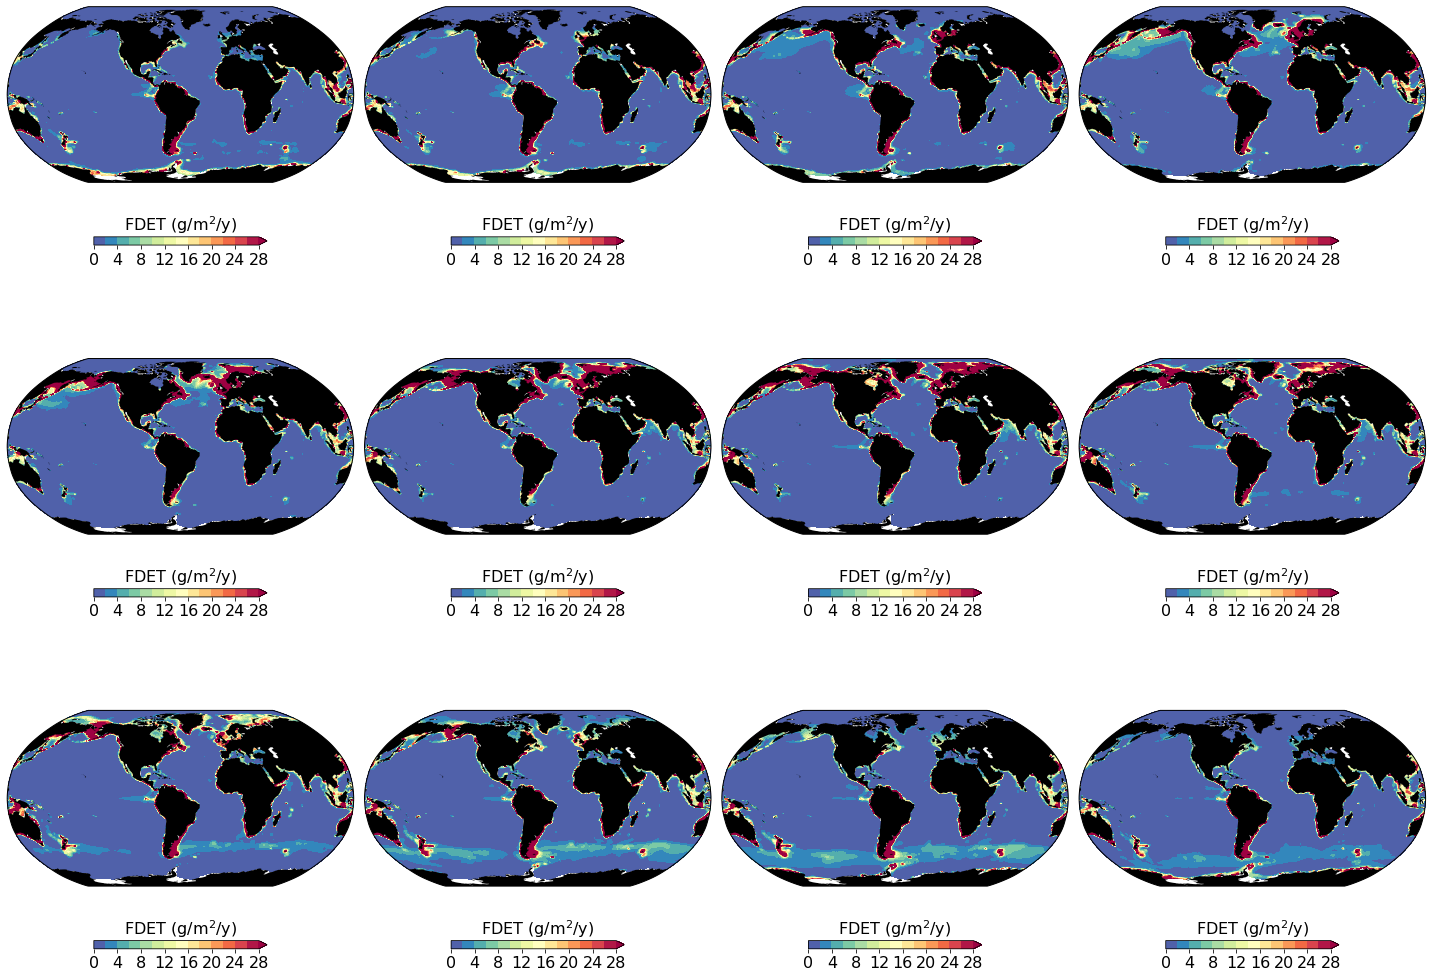

In [13]:
fig = plt.figure(figsize=(20, 20))
lev = np.arange(0, 30, 2)
for i in range(12): 
    norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=15)
    lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, flux_bottom_depth[i,:,:])
    ax = fig.add_subplot(4, 4, i+1, projection=ccrs.Robinson(central_longitude=305.0))
    cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm,extend = 'max', transform=ccrs.PlateCarree());
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
    cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
    ax.set_global()
    cb.ax.set_title('FDET (g/m$^2$/y)', fontsize = 16)
    cb.ax.tick_params(labelsize=16)
    fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/FDET_seasonal.png',dpi=200, bbox_inches='tight')

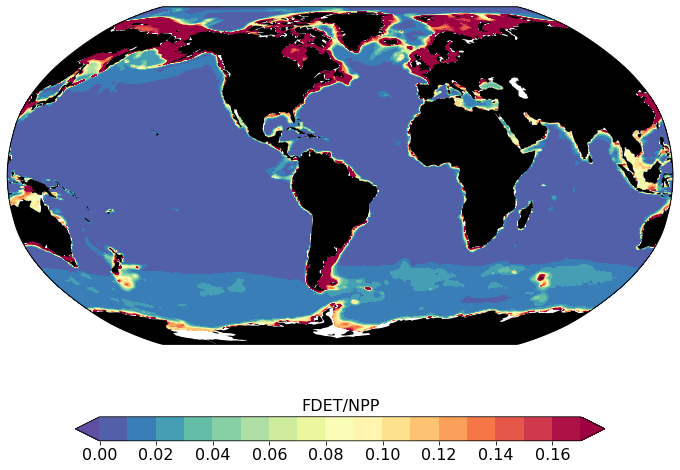

In [14]:
fig = plt.figure(figsize=(15, 7))
lev = np.arange(0, 0.18, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.09)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(flux_bottom_depth,axis=0)/total_npp)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_global()
cb.ax.set_title('FDET/NPP', fontsize = 16)
cb.ax.tick_params(labelsize=16)
fig.tight_layout()

### __MESOZP__ = mesozooplankton production not consumed by other zooplankton
* Here, I will use zooplankton production - zooplankton grazing on zooplankton of each category

In [15]:
# sum of Mesozooplankton Grazing Gain Vertical Integral mol/m^3 cm/s
zoo_names = ['zoo3','zoo4','zoo5','zoo6']
ds['zooGraz'] = xr.concat([ds['x_graze_' + v + '_zint'] for v in zoo_names], dim='var').sum(dim='var')* 1e-2 # units are mmol m-2 s-1
zooGraz_TOT = ds.zooGraz *(60*60*24*365) * 1.2011e-2 # to g C / m^2 y

In [16]:
# zooplankton Linear loss vertical Intergral mmol/m^3 cm/s
zoo_names = ['zoo3','zoo4','zoo5','zoo6']
ds['zooLoss'] = xr.concat([ds[''+ v + '_linear_loss_zint_100m'] for v in zoo_names], dim='var').sum(dim='var')* 1e-2 # units are mmol m-2 s-1
zooloss_TOT = ds.zooLoss *(60*60*24*365) * 1.2011e-2 # to g C / m^2 y

### ds.zoo1_linear_loss_zint_100m OR ds.zoo1_linear_loss_zint
* max zoo production with zoo1_linear_loss_zint_100m is 54.58, and min is -1.4
* max zoo production with zoo1_linear_loss_zint is 45.77, and min is -7.14

In [17]:
zooProduction = np.subtract(zooGraz_TOT, zooloss_TOT)
zooProduction_updated = np.where(zooProduction<0, 0, zooProduction)

In [18]:
np.nanmax(zooProduction_updated)

54.58094287358638

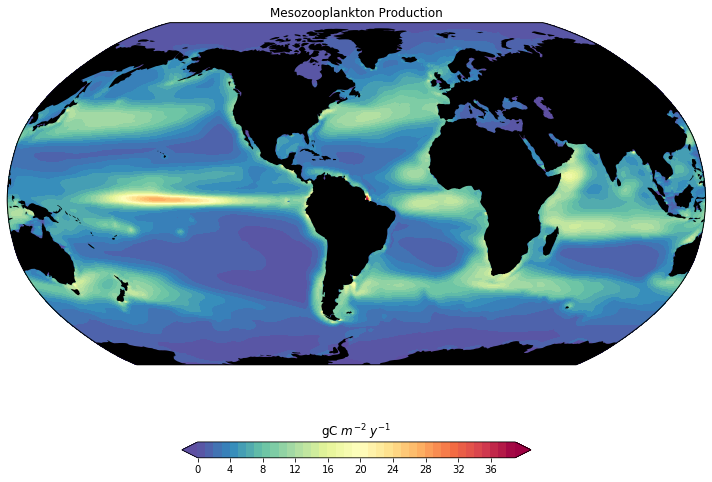

In [19]:
lev = np.arange(0, 40, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=20)

fig = plt.figure(figsize=(10, 7.5))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(zooProduction_updated,axis=0))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('gC $m^{-2}$ $y^{-1}$')
ax.set_title('Mesozooplankton Production');
plt.tight_layout()

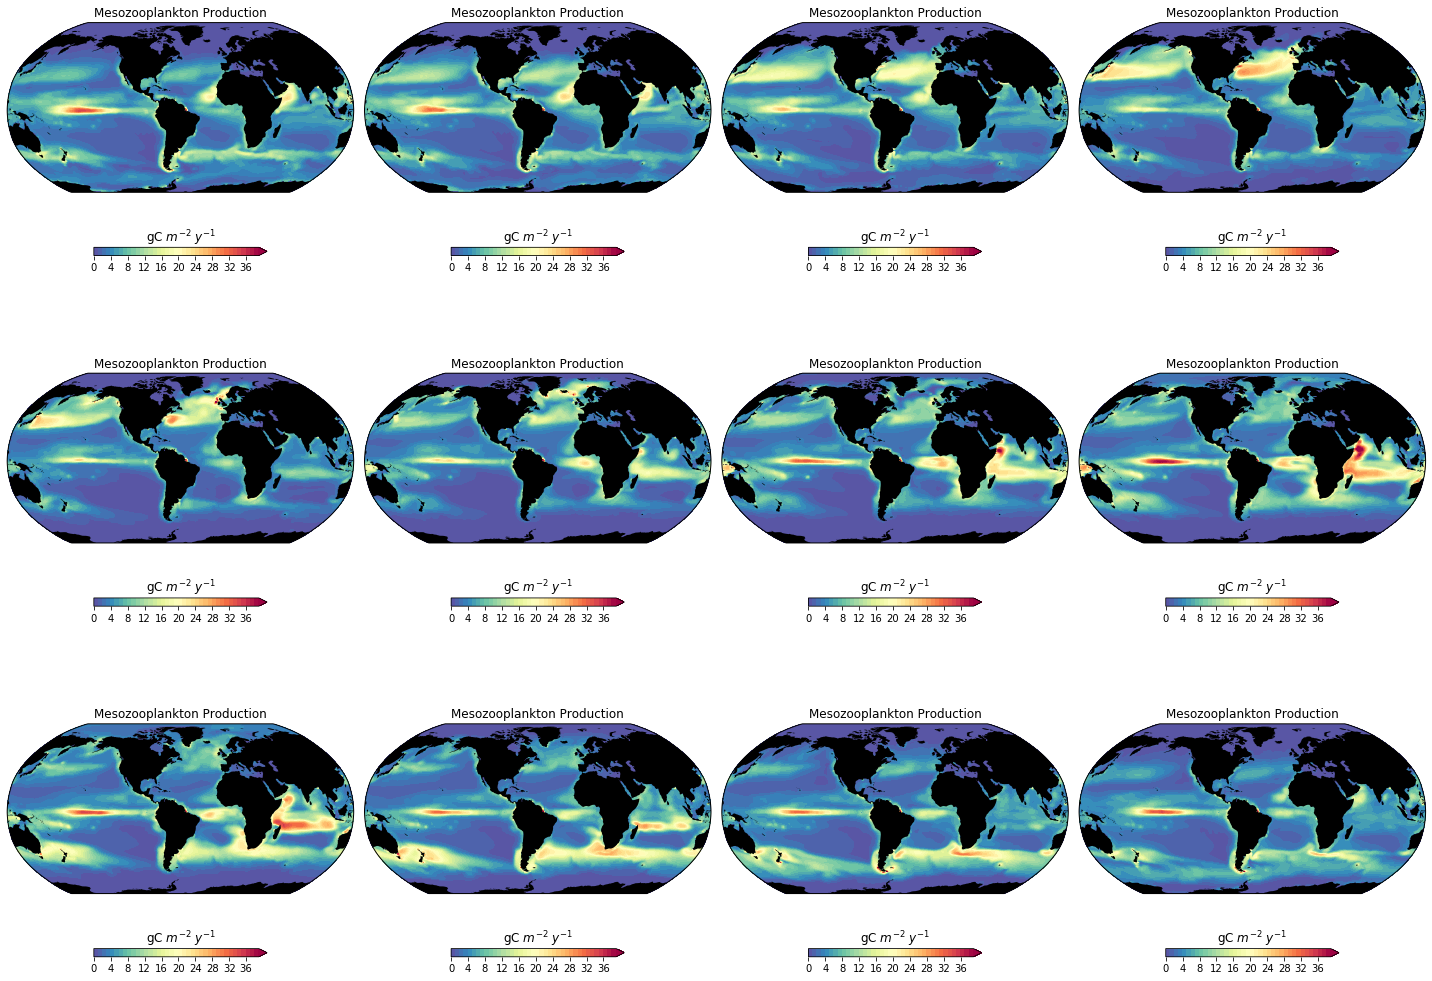

In [20]:
fig = plt.figure(figsize=(20, 20))
lev = np.arange(0, 40, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=20)
for i in range(12): 
    lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, zooProduction_updated[i,:,:])
    ax = fig.add_subplot(4, 4, i+1, projection=ccrs.Robinson(central_longitude=305.0))
    cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'max',transform=ccrs.PlateCarree());
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
    cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
    cb.ax.set_title('gC $m^{-2}$ $y^{-1}$')
    ax.set_title('Mesozooplankton Production');
    plt.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/MESOZP_seasonal.png',dpi=200, bbox_inches='tight')

In [21]:
# Mesozooplankton production.. 
zoo3_prod = np.subtract(ds.x_graze_zoo3_zint, ds.zoo3_linear_loss_zint_100m)
zoo4_prod = np.subtract(ds.x_graze_zoo4_zint, ds.zoo4_linear_loss_zint_100m)
zoo5_prod = np.subtract(ds.x_graze_zoo5_zint, ds.zoo5_linear_loss_zint_100m)
zoo6_prod = np.subtract(ds.x_graze_zoo6_zint, ds.zoo6_linear_loss_zint_100m)

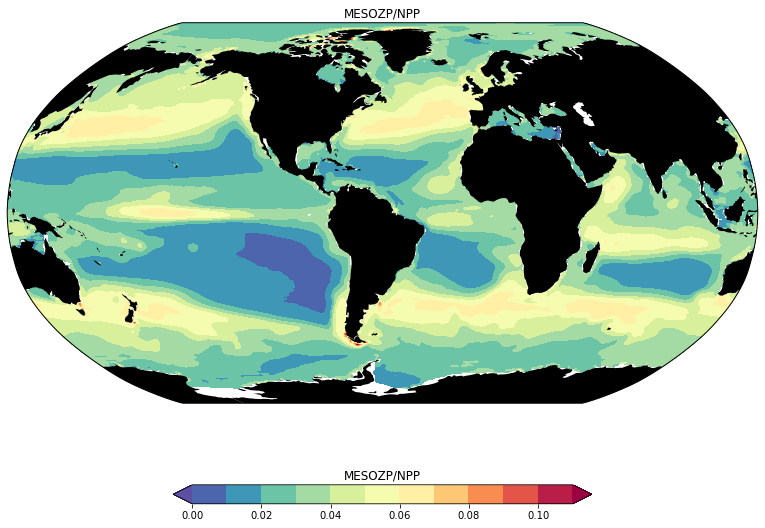

In [22]:
fig = plt.figure(figsize=(15, 10))
lev = np.arange(0, 0.12, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.06)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(zooProduction_updated,axis=0)/total_npp)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('MESOZP/NPP')
ax.set_title('MESOZP/NPP');

### Grazing flux based on trophic level 

In [23]:
## Gaby's Path 
jluo_path = '/glade/u/home/jluo/cesm_scripts/size_structured/nl_input/cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
gabyn_path = '/glade/u/home/gabyn/case_notes/spectral_cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
nl_config = os.path.join(''+gabyn_path+'GNG595/data/')
sizes = pd.read_csv(nl_config+'plankton_sizes.csv')
sizes = sizes.sort_values('mmolC')
sizes

type  sname      mass_ugC       vol_um3     ESD_mm  Qp_fixed  \
1   phyto     pp  9.266989e-08  3.706795e-01   0.000891  0.004651   
2   phyto    mp1  8.241979e-06  1.805089e+01   0.003255  0.006824   
0   phyto   diaz  5.499929e-05  1.227865e+02   0.006167  0.003333   
3   phyto    mp2  8.888712e-05  8.790197e+02   0.011885  0.008656   
6   phyto  diat1  5.004513e-04  1.327390e+04   0.029376  0.010289   
9     zoo   zoo1  2.803686e-03  2.355042e+04   0.035563  0.008547   
7   phyto  diat2  3.803133e-03  1.326626e+05   0.063278  0.012602   
4   phyto    mp3  4.830334e-03  4.280541e+04   0.043401  0.012907   
8   phyto  diat3  2.890156e-02  1.325863e+06   0.136301  0.015435   
10    zoo   zoo2  8.933984e-02  7.447577e+05   0.112462  0.008547   
5   phyto    mp4  1.855836e-01  2.084484e+06   0.158489  0.018590   
11    zoo   zoo3  2.825280e+00  2.355219e+07   0.355640  0.008547   
12    zoo   zoo4  8.934658e+01  7.448139e+08   1.124647  0.008547   
13    zoo   zoo5  2.825494e+03  2.355397e+10   3.556492  0.008547   
14    zoo   zoo6  8.935332e+04  7.448701e+11  11.246757  0.008547   

           mmolC  
1   7.715418e-12  
2   6.862025e-10  
0   4.579077e-09  
3   7.400476e-09  
6   4.166608e-08  
9   2.334265e-07  
7   3.166375e-07  
4   4.021592e-07  
8   2.406258e-06  
10  7.438168e-06  
5   1.545114e-05  
11  2.352244e-04  
12  7.438730e-03  
13  2.352422e-01  
14  7.439291e+00

In [24]:
ZooTL_g = np.load("zoo_mean_TL.npy")

In [25]:
ZooTL_g.shape

(12, 15, 384, 320)

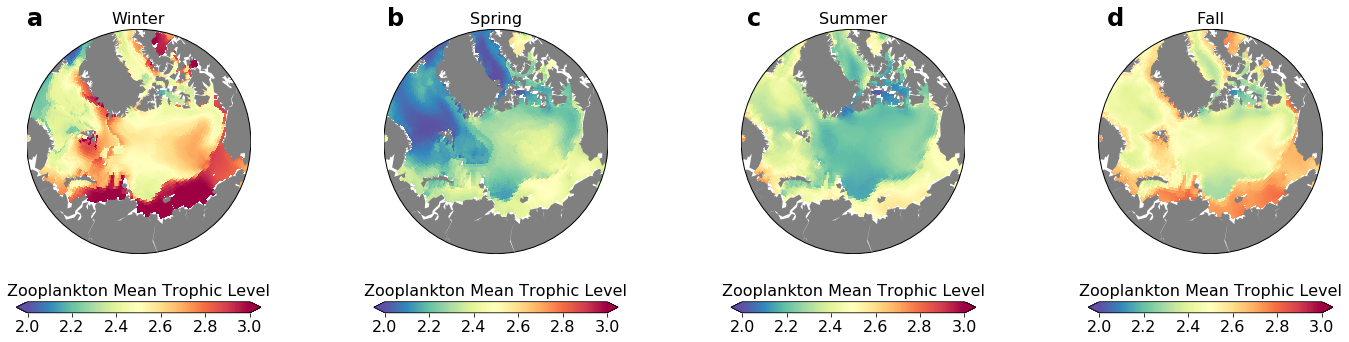

In [48]:
from mpl_toolkits.basemap import Basemap
lev = np.arange(2, 3, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.5)
fig = plt.figure(figsize=(20, 5))

# Winter TL3
ax = fig.add_subplot(1, 4, 1)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ZooTL_g[list(range(2)) + [-1],:,:,:],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',vmin=2,vmax=3);
cb = plt.colorbar(cf, shrink=0.75, extend ='both',orientation='horizontal')
cb.ax.set_title('Zooplankton Mean Trophic Level', fontsize=16)
ax.set_title('Winter', fontsize =16)
cb.ax.tick_params(labelsize=16)

# SPring TL3
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ZooTL_g[2:5,:,:,:],axis=(0,1)))
ax = fig.add_subplot(1, 4, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',vmin=2,vmax=3);
cb = plt.colorbar(cf, shrink=0.75, extend ='both',orientation='horizontal')
cb.ax.set_title('Zooplankton Mean Trophic Level', fontsize=16)
ax.set_title('Spring', fontsize =16)
cb.ax.tick_params(labelsize=16)

# January TLeq = 2, TL global average month of january 
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ZooTL_g[5:8,:,:,:],axis=(0,1)))
ax = fig.add_subplot(1, 4, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',vmin=2,vmax=3);
cb = plt.colorbar(cf, shrink=0.75, extend ='both',orientation='horizontal')
cb.ax.set_title('Zooplankton Mean Trophic Level', fontsize=16)
ax.set_title('Summer', fontsize =16)
cb.ax.tick_params(labelsize=16)

# January TLeq = 2, TL global average month of january 
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ZooTL_g[8:11,:,:,:],axis=(0,1)))
ax = fig.add_subplot(1, 4, 4)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',vmin=2,vmax=3);
cb = plt.colorbar(cf, shrink=0.75, extend ='both',orientation='horizontal')
cb.ax.set_title('Zooplankton Mean Trophic Level', fontsize=16)
ax.set_title('Fall', fontsize =16)
cb.ax.tick_params(labelsize=16)
fig.text(0.05, 0.93, 'a',fontsize=24, fontweight='bold')
fig.text(0.3, 0.93, 'b',fontsize=24, fontweight='bold')
fig.text(0.55, 0.93, 'c',fontsize=24, fontweight='bold')
fig.text(0.80, 0.93, 'd',fontsize=24, fontweight='bold')

plt.tight_layout()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/quarterly_TL_20yrclim_top150m.png',dpi=200, bbox_inches='tight')

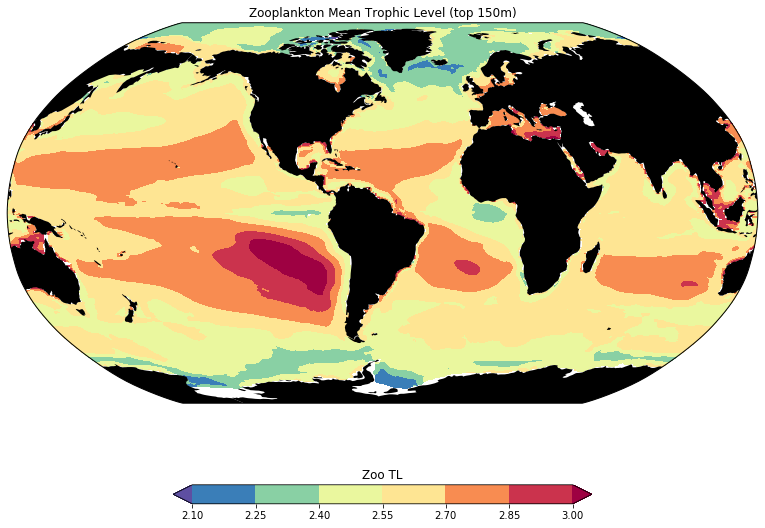

In [26]:
fig = plt.figure(figsize=(15, 10))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ZooTL_g,axis=(0,1)))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',extend='both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('Zoo TL')
ax.set_title('Zooplankton Mean Trophic Level (top 150m)');

### Calculating fish Catch 

In [27]:
alpha = 0.5 # ranges from 0 to 1 
FDET = np.nanmean(flux_bottom_depth,axis=0) # POC Flux into Cell (mmol/m^3 cm/s) to g C / m^2 s
TE = 0.2 # ranges from 0 to 0.4 
TE_eq = 2 # trophic level (np.nanmean(ZooTL_g,axis=(0,1,2,3))) ---> (2.5885172746837832)
MESOZP =  np.nanmean(zooProduction_updated,axis=0) # g C / m^2 s

In [28]:
np.nanmin(zooProduction_updated)

0.0

### Let's make sure that this equation is showing everything correctly! 

In [29]:
a = FDET*TE**(TE_eq-1)
b = MESOZP*TE**(TE_eq-np.nanmean(ZooTL_g,axis=(0,1,2,3)))

In [30]:
Catch = alpha*((FDET*TE**(TE_eq-1))+(MESOZP*TE**(TE_eq-np.nanmean(ZooTL_g,axis=(0,1,2,3)))))

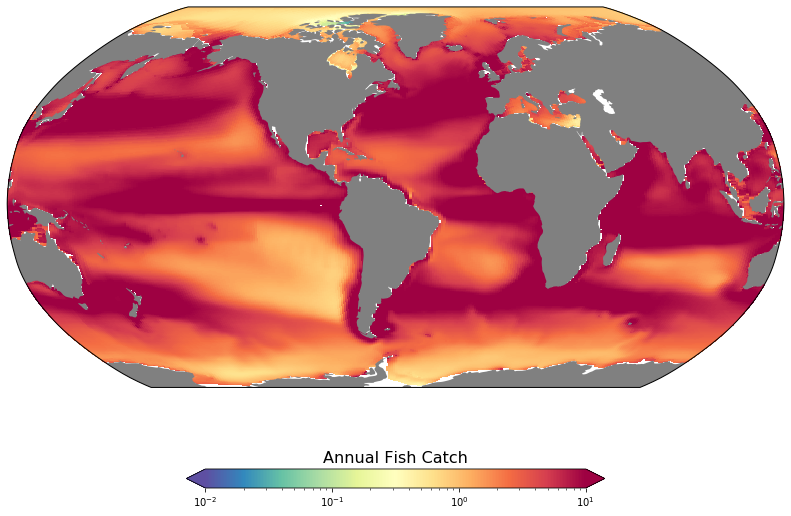

In [31]:
fig = plt.figure(figsize=(15, 10))
lev = np.arange(0, 1, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10),transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, shrink=0.5, extend = 'both',orientation='horizontal')
cb.ax.set_title('Annual Fish Catch', fontsize=16)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/annual_catch_global_TLeq2_2_6.png',dpi=200, bbox_inches='tight')

## Seasonal Fish Catch! 

In [32]:
alpha = 0.5 # ranges from 0 to 1 
FDET = flux_bottom_depth # POC Flux into Cell (mmol/m^3 cm/s) to g C / m^2 s
TE = 0.2 # ranges from 0 to 0.4 
TE_eq = 2 # trophic level 
MESOZP =  zooProduction_updated # g C / m^2 s

In [33]:
ZooTL_g.shape

(12, 15, 384, 320)

In [34]:
Catch_monthly = np.empty([12,384,320])
Catch_monthly[:]= np.nan
for i in range(12):
    Catch_monthly[i,:,:] = alpha*((FDET[i,:,:]*TE**(TE_eq-1))+(MESOZP[i,:,:]*TE**(TE_eq-np.nanmean(ZooTL_g[i,:,:,:],axis=(0,1,2)))))

In [35]:
np.nanmin(MESOZP)

0.0

In [36]:
label = ['01','02','03','04','05','06','07','08','09','10','11','12']
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
for i in range(12):
    print(''+months[i]+' Fish Catch')

January Fish Catch
February Fish Catch
March Fish Catch
April Fish Catch
May Fish Catch
June Fish Catch
July Fish Catch
August Fish Catch
September Fish Catch
October Fish Catch
November Fish Catch
December Fish Catch


lev = np.arange(0, 1, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
label = ['01','02','03','04','05','06','07','08','09','10','11','12']

for i in range(12): 
    fig = plt.figure(figsize=(15, 10))
    lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch_monthly_TLeq3[i,:,:])
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
    cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.0001, vmax=10),transform=ccrs.PlateCarree());
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
    cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
    cb.ax.set_title(''+months[i]+' Fish Catch', fontsize=16)
    fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/0'+label[i]+'_catch_global_TLeq3.png',dpi=200, bbox_inches='tight')

## Create a subplot figure that has January, April, July and October with trophic level 2 on top, and trophic level 3 on the bottom, it should be 2 by 4. 

In [37]:
alpha = 0.5 # ranges from 0 to 1 
FDET = flux_bottom_depth # POC Flux into Cell (mmol/m^3 cm/s) to g C / m^2 s
TE = 0.2 # ranges from 0 to 0.4 
TE_eq = 3 # trophic level 
MESOZP =  zooProduction_updated # g C / m^2 s

In [38]:
Catch_monthly_TLeq3 = np.empty([12,384,320])
Catch_monthly_TLeq3[:]= np.nan
for i in range(12):
    Catch_monthly_TLeq3[i,:,:] = alpha*((FDET[i,:,:]*TE**(TE_eq-1))+(MESOZP[i,:,:]*TE**(TE_eq-np.nanmean(ZooTL_g[i,:,:,:],axis=(0,1,2)))))

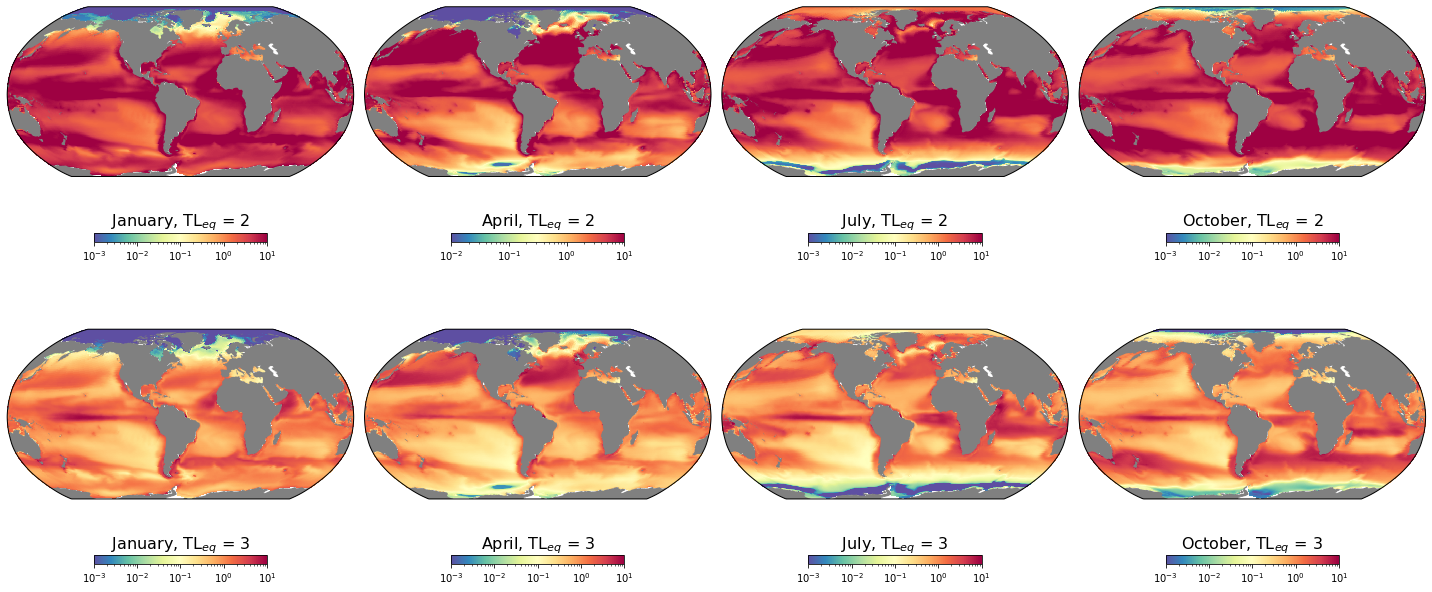

In [30]:
lev = np.arange(0, 1, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 10))

# January TLeq = 2, TL global average month of january 
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch_monthly[0,:,:])
ax = fig.add_subplot(2, 4, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.001, vmax=10),transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title(''+months[0]+', TL$_{eq}$ = 2', fontsize=16)

# April TLeq = 2, TL global average month of january 
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch_monthly[3,:,:])
ax = fig.add_subplot(2, 4, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10),transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title(''+months[3]+', TL$_{eq}$ = 2', fontsize=16)

# January TLeq = 2, TL global average month of january 
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch_monthly[6,:,:])
ax = fig.add_subplot(2, 4, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.001, vmax=10),transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title(''+months[6]+', TL$_{eq}$ = 2', fontsize=16)

# January TLeq = 2, TL global average month of january 
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch_monthly[9,:,:])
ax = fig.add_subplot(2, 4, 4, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.001, vmax=10),transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title(''+months[9]+', TL$_{eq}$ = 2', fontsize=16)

# January TLeq = 2, TL global average month of january 
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch_monthly_TLeq3[0,:,:])
ax = fig.add_subplot(2, 4, 5, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.001, vmax=10),transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title(''+months[0]+', TL$_{eq}$ = 3', fontsize=16)

# April TLeq = 2, TL global average month of january 
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch_monthly_TLeq3[3,:,:])
ax = fig.add_subplot(2, 4, 6, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.001, vmax=10),transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title(''+months[3]+', TL$_{eq}$ = 3', fontsize=16)

# January TLeq = 2, TL global average month of january 
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch_monthly_TLeq3[6,:,:])
ax = fig.add_subplot(2, 4, 7, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.001, vmax=10),transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title(''+months[6]+', TL$_{eq}$ = 3', fontsize=16)

# January TLeq = 2, TL global average month of january 
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch_monthly_TLeq3[9,:,:])
ax = fig.add_subplot(2, 4, 8, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.001, vmax=10),transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title(''+months[9]+', TL$_{eq}$ = 3', fontsize=16)
plt.tight_layout()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/quarterly_catch_global_TLeq2&3.png',dpi=200, bbox_inches='tight')

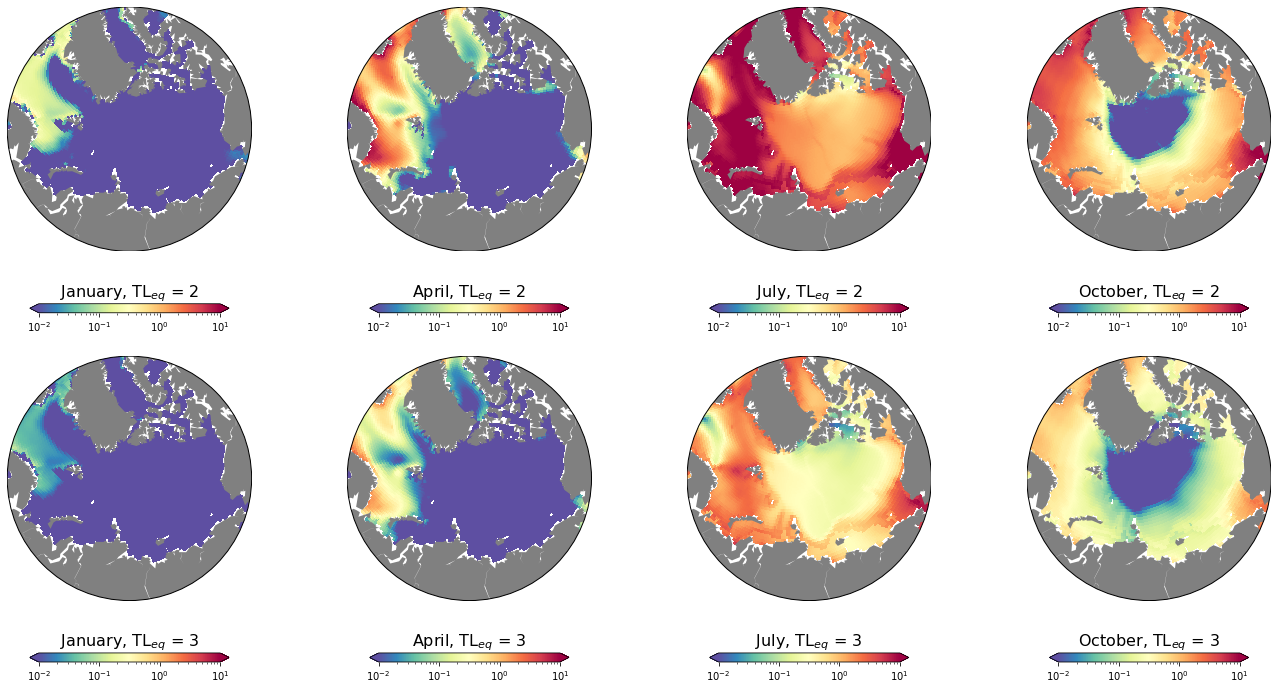

In [31]:
from mpl_toolkits.basemap import Basemap
lev = np.arange(0, 1, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 10))

# January TLeq = 2, TL global average month of january 
ax = fig.add_subplot(2, 4, 1)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch_monthly[0,:,:])
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(''+months[0]+', TL$_{eq}$ = 2', fontsize=16)

# April TLeq = 2, TL global average month of january 
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch_monthly[3,:,:])
ax = fig.add_subplot(2, 4, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(''+months[3]+', TL$_{eq}$ = 2', fontsize=16)

# January TLeq = 2, TL global average month of january 
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch_monthly[6,:,:])
ax = fig.add_subplot(2, 4, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(''+months[6]+', TL$_{eq}$ = 2', fontsize=16)

# January TLeq = 2, TL global average month of january 
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch_monthly[9,:,:])
ax = fig.add_subplot(2, 4, 4)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(''+months[9]+', TL$_{eq}$ = 2', fontsize=16)

# January TLeq = 2, TL global average month of january 
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch_monthly_TLeq3[0,:,:])
ax = fig.add_subplot(2, 4, 5)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(''+months[0]+', TL$_{eq}$ = 3', fontsize=16)

# April TLeq = 2, TL global average month of january 
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch_monthly_TLeq3[3,:,:])
ax = fig.add_subplot(2, 4, 6)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(''+months[3]+', TL$_{eq}$ = 3', fontsize=16)

# January TLeq = 2, TL global average month of january 
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch_monthly_TLeq3[6,:,:])
ax = fig.add_subplot(2, 4, 7)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(''+months[6]+', TL$_{eq}$ = 3', fontsize=16)

# January TLeq = 2, TL global average month of january 
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch_monthly_TLeq3[9,:,:])
ax = fig.add_subplot(2, 4, 8)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(''+months[9]+', TL$_{eq}$ = 3', fontsize=16)
plt.tight_layout()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/quarterly_catch_AO_TLeq2&3.png',dpi=200, bbox_inches='tight')

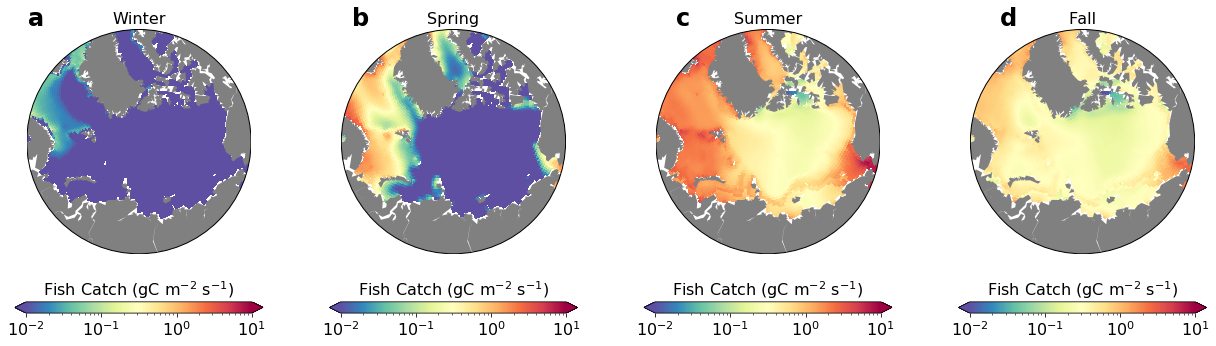

In [49]:
from mpl_toolkits.basemap import Basemap
lev = np.arange(0, 1, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(18, 5))

# Winter TL3
ax = fig.add_subplot(1, 4, 1)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(Catch_monthly_TLeq3[list(range(2)) + [-1],:,:],axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.75, extend ='both',orientation='horizontal')
cb.ax.set_title('Fish Catch (gC m$^{-2}$ s$^{-1}$)', fontsize=16)
ax.set_title('Winter', fontsize =16)
cb.ax.tick_params(labelsize=16)

# SPring TL3
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(Catch_monthly_TLeq3[2:5,:,:],axis=0))
ax = fig.add_subplot(1, 4, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.75, extend ='both',orientation='horizontal')
cb.ax.set_title('Fish Catch (gC m$^{-2}$ s$^{-1}$)', fontsize=16)
ax.set_title('Spring', fontsize =16)
cb.ax.tick_params(labelsize=16)

# January TLeq = 2, TL global average month of january 
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(Catch_monthly_TLeq3[5:8,:,:],axis=0))
ax = fig.add_subplot(1, 4, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.75, extend ='both',orientation='horizontal')
cb.ax.set_title('Fish Catch (gC m$^{-2}$ s$^{-1}$)', fontsize=16)
ax.set_title('Summer', fontsize =16)
cb.ax.tick_params(labelsize=16)

# January TLeq = 2, TL global average month of january 
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(Catch_monthly_TLeq3[8:11,:,:],axis=0))
ax = fig.add_subplot(1, 4, 4)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.75, extend ='both',orientation='horizontal')
cb.ax.set_title('Fish Catch (gC m$^{-2}$ s$^{-1}$)', fontsize=16)
ax.set_title('Fall', fontsize =16)
cb.ax.tick_params(labelsize=16)
fig.text(0.05, 0.93, 'a',fontsize=24, fontweight='bold')
fig.text(0.3, 0.93, 'b',fontsize=24, fontweight='bold')
fig.text(0.55, 0.93, 'c',fontsize=24, fontweight='bold')
fig.text(0.80, 0.93, 'd',fontsize=24, fontweight='bold')

plt.tight_layout()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/quarterly_catch_AO_TLeq3_20yrclim.png',dpi=200, bbox_inches='tight')